In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA(GPU)를 사용합니다.")
else:
    device = torch.device("cpu")
    print("CUDA(GPU)를 사용할 수 없으므로, CPU를 사용합니다.")

CUDA(GPU)를 사용할 수 없으므로, CPU를 사용합니다.


# 의류 분류

In [3]:
# 데이터 불러오기
df = pd.read_csv('styles.csv', on_bad_lines='skip')

In [4]:
# 필요한 컬럼 추출
df = df[['id', 'subCategory']]

# 카테고리 변경
df.loc[df['subCategory'].isin(['Sandal', 'Flip Flops']), 'subCategory'] = 'Shoes'
df.loc[df['subCategory'].isin(['Dress']), 'subCategory'] = 'Topwear'

# Label 데이터프레임 생성
label_df = df[df['subCategory'].isin(['Topwear', 'Shoes', 'Bags','Bottomwear', 'Watches', 'Innerwear', 'Eyewear', 'Wallets', 'Belts'])]

In [5]:
label_df

,id,subCategory
0,15970,Topwear
1,39386,Bottomwear
2,59263,Watches
3,21379,Bottomwear
4,53759,Topwear
...,...,...
44418,42234,Topwear
44419,17036,Shoes
44420,6461,Shoes
44421,18842,Topwear


In [6]:
label_df.subCategory.unique()

array(['Topwear', 'Bottomwear', 'Watches', 'Shoes', 'Belts', 'Bags',
       'Innerwear', 'Eyewear', 'Wallets'], dtype=object)

In [7]:
# 파일 크기 조정
target_size = (56, 56)  # 원하는 크기로 변경

# 조정한 파일 리스트화
resized_images = []

for filename in os.listdir('images'):
    filepath = os.path.join('images', filename)
    img = cv2.imread(filepath)
    resized_img = cv2.resize(img, target_size)
    resized_images.append(resized_img)

KeyboardInterrupt: 

In [ ]:
# 파일 불러오기
dir = './resized_images/'  # 경로 지정
train_images = []

for i in range(len(df[:10000])):
    try:
        file = str(df.id[i]) + '.jpg'
        img = cv2.imread(dir + file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        train_images.append(img)
    except:
        pass

train_images = np.array(train_images)
train_images = train_images / 255.0  # 정규화
train_images.shape

(9993, 224, 224, 3)

In [ ]:
encoder = LabelEncoder()

labels = encoder.fit_transform(label_df.subCategory.unique())

labels

# Garbage image

In [4]:
pd.DataFrame(img_dir, columns=["files_name"])

,files_name
0,battery
1,biological
2,brown-glass
3,cardboard
4,clothes
5,green-glass
6,metal
7,paper
8,plastic
9,shoes


In [7]:
import glob

In [15]:
files = [i for i in glob.glob('garbage_classification' + "//*//*")]
np.random.shuffle(files)
labels = [os.path.dirname(i).split("\\")[-1] for i in files]
data = zip(files, labels)
dataframe = pd.DataFrame(data, columns = ["Image", "Label"])
dataframe

,Image,Label
0,garbage_classification\shoes\shoes184.jpg,shoes
1,garbage_classification\clothes\clothes4027.jpg,clothes
2,garbage_classification\paper\paper473.jpg,paper
3,garbage_classification\trash\trash472.jpg,trash
4,garbage_classification\clothes\clothes2541.jpg,clothes
...,...,...
15505,garbage_classification\metal\metal79.jpg,metal
15506,garbage_classification\clothes\clothes4848.jpg,clothes
15507,garbage_classification\brown-glass\brown-glass...,brown-glass
15508,garbage_classification\clothes\clothes2946.jpg,clothes


In [16]:
dataframe.Label.value_counts()

Label
clothes        5325
shoes          1977
paper          1050
biological      985
battery         940
cardboard       891
plastic         865
white-glass     775
metal           769
trash           697
green-glass     629
brown-glass     607
Name: count, dtype: int64

In [19]:
dataframe.Label.value_counts() / len(dataframe) * 100

Label
clothes        34.332689
shoes          12.746615
paper           6.769826
biological      6.350741
battery         6.060606
cardboard       5.744681
plastic         5.577047
white-glass     4.996776
metal           4.958092
trash           4.493875
green-glass     4.055448
brown-glass     3.913604
Name: count, dtype: float64

In [21]:
result = dataframe.Label.value_counts() / len(dataframe) * 100
rounded_result = round(result, 2)
formatted_result = rounded_result.map("{:.2f}%".format)
print(formatted_result)

Label
clothes        34.33%
shoes          12.75%
paper           6.77%
biological      6.35%
battery         6.06%
cardboard       5.74%
plastic         5.58%
white-glass     5.00%
metal           4.96%
trash           4.49%
green-glass     4.06%
brown-glass     3.91%
Name: count, dtype: object


In [3]:
# 이미지를 불러올 폴더 지정
img_dir = os.listdir('garbage_classification/')
print(img_dir)

['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [5]:
label_list = os.listdir('garbage_classification')
print(label_list)

['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [70]:
# 각 폴더에서 하나의 이미지만 불러오기
show_img = []
for dir in os.listdir('garbage_classification'):
    show_img.append(dir + '/' + os.listdir(f'garbage_classification/{dir}')[0])
    
print(show_img)

['battery/battery103.jpg', 'biological/biological1.jpg', 'brown-glass/brown-glass1.jpg', 'cardboard/cardboard1.jpg', 'clothes/clothes1.jpg', 'green-glass/green-glass1.jpg', 'metal/metal1.jpg', 'paper/paper1.jpg', 'plastic/plastic1.jpg', 'shoes/shoes1.jpg', 'trash/trash1.jpg', 'white-glass/white-glass1.jpg']


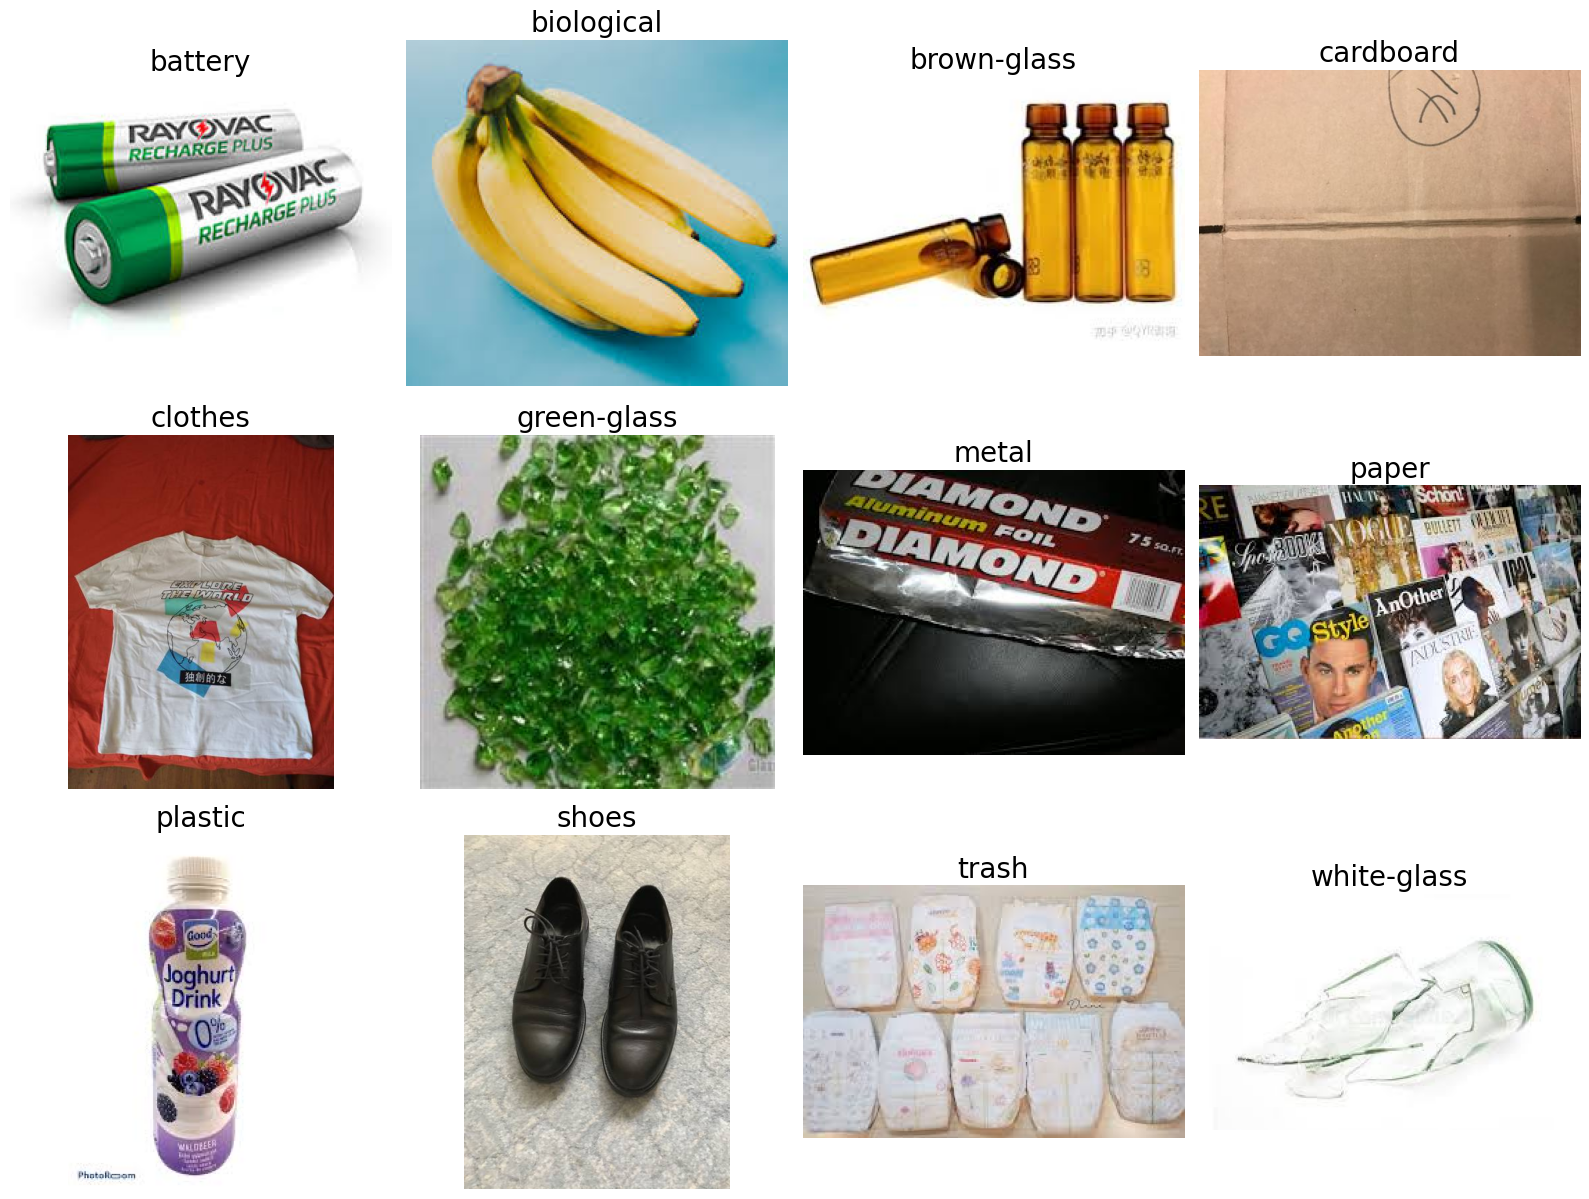

In [78]:
# 이미지 시각화
num_cols = 4
num_rows = len(show_img) // num_cols + (len(show_img) % num_cols > 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 4*num_rows))

for i, img in enumerate(show_img):
    row = i // num_cols
    col = i % num_cols
    
    imgs = cv2.imread(f'garbage_classification/{img}')
    imgs = cv2.cvtColor(imgs, cv2.COLOR_BGR2RGB)
    
    axes[row, col].imshow(imgs)
    axes[row, col].set_title(img.split('/')[0], fontsize=20)
    axes[row, col].axis('off')

# subplot이 사용되지 않은 빈 공간 제거
for i in range(len(show_img), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

In [6]:
# image와 label을 불러오는 함수
def load_images_and_labels(folder_path: str):
    """
    주어진 폴더 경로에서 이미지 파일을 읽어들여서 이미지와 라벨을 반환하는 함수입니다.
    folder_path: 이미지 파일들이 있는 폴더의 경로
    return: train_images, train_labels
    """
    # 라벨과 이미지를 저장할 리스트 초기화
    train_images = []
    train_labels = []
    test_images = []
    test_labels = []

    # 폴더 label을 숫자로 변환
    label_counter = 0

    # 각 라벨 폴더에 대해 반복
    for label_folder in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label_folder)

        # 디렉토리인지 확인하고, 디렉토리라면 이미지 파일들을 읽어들여서 처리
        if os.path.isdir(label_path):
            # 숫자 라벨 할당
            label = label_counter
            label_counter += 1

            # 해당 라벨 폴더 안의 이미지 파일들을 읽어들여서 배열에 추가
            images_in_label = []
            labels_in_label = []
            for image_file in os.listdir(label_path):
                image_path = os.path.join(label_path, image_file)

                # 이미지 읽기
                image = cv2.imread(image_path)
                
                # 이미지가 읽히는 경우
                if image is not None:
                    # 이미지를 원하는 크기로 조절
                    image = cv2.resize(image, (64, 64))

                    # 해당 라벨의 이미지 배열에 추가
                    images_in_label.append(image)
                    # 해당 라벨의 라벨 배열에 추가
                    labels_in_label.append(label)

            # 라벨 폴더에서 80% 비율만 선택하여 train 데이터에 추가
            num_train_images = int(len(images_in_label) * 0.8)
            train_images.extend(images_in_label[:num_train_images])
            train_labels.extend(labels_in_label[:num_train_images])
            
            # 라벨 폴더에서 20% 비율만 선택하여 test 데이터에 추가
            test_images.extend(images_in_label[num_train_images:])
            test_labels.extend(labels_in_label[num_train_images:])

    # 리스트를 numpy 배열로 변환
    train_images = np.array(train_images)
    train_labels = np.array(train_labels)
    test_images = np.array(test_images)
    test_labels = np.array(test_labels)

    return train_images, train_labels, test_images, test_labels

# 이미지와 라벨을 불러오기
train_images, train_labels, test_images, test_labels = load_images_and_labels("garbage_classification")

# 결과 확인
print("Train images shape:", train_images.shape)
print("Train labels:", train_labels)
print("Test images shape:", test_images.shape)
print("Test labels:", test_labels)

Train images shape: (12405, 64, 64, 3)
Train labels: [ 0  0  0 ... 11 11 11]
Test images shape: (3105, 64, 64, 3)
Test labels: [ 0  0  0 ... 11 11 11]


In [8]:
# 데이터셋 정의
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = torch.LongTensor(labels)  # 명시적으로 Long 타입으로 변환
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [9]:
# numpy 배열을 float32로 변환
train_images_float32 = train_images.astype(np.float32)
test_images_float32 = test_images.astype(np.float32)

# 데이터 로더 설정
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_dataset = CustomDataset(train_images_float32, train_labels, transform=transform)
test_dataset = CustomDataset(test_images_float32, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

In [7]:
# myCNN 클래스 정의
class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=2)
        self.fc1 = nn.Linear(64*9*9, 64)
        self.fc2 = nn.Linear(64, 12)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, 64*9*9)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

In [8]:
# 모델, 손실 함수, 최적화 알고리즘 설정
model = myCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# 손실과 정확도를 저장하기 위한 리스트 초기화
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [13]:
# 훈련 함수
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        if torch.cuda.is_available():
            data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    # 예측값 계산(가장 높은 값을 가진 인덱스)
    _, predicted = torch.max(output.data, 1)
    total += target.size(0)
    # 올바르게 예측된 샘플의 수 업데이트
    correct += (predicted == target).sum().item()

    # 평균 훈련 손실 계산
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    print(f'Epoch: {epoch}, Training loss: {train_loss:.4f}')
    accuracy = 100. * correct / total
    train_accuracies.append(accuracy)  # 정확도 기록을 위한 리스트에 추가

In [14]:
# 테스트 함수
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if torch.cuda.is_available():
                data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f'Test loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return test_loss  # 손실 반환

In [11]:
# 훈련 및 테스트 실행
for epoch in range(1, 10):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch: 1, Training loss: 2.0347
Test loss: 1.9495, Accuracy: 38.33%
Epoch: 2, Training loss: 1.8073
Test loss: 1.8925, Accuracy: 42.48%
Epoch: 3, Training loss: 1.6559
Test loss: 1.7716, Accuracy: 43.19%
Epoch: 4, Training loss: 1.5523
Test loss: 1.8460, Accuracy: 39.61%
Epoch: 5, Training loss: 1.4347
Test loss: 1.5784, Accuracy: 48.12%
Epoch: 6, Training loss: 1.2906
Test loss: 1.3591, Accuracy: 55.68%
Epoch: 7, Training loss: 1.1884
Test loss: 1.3198, Accuracy: 55.68%
Epoch: 8, Training loss: 1.1070
Test loss: 1.2206, Accuracy: 60.64%
Epoch: 9, Training loss: 1.0312
Test loss: 1.1655, Accuracy: 62.19%


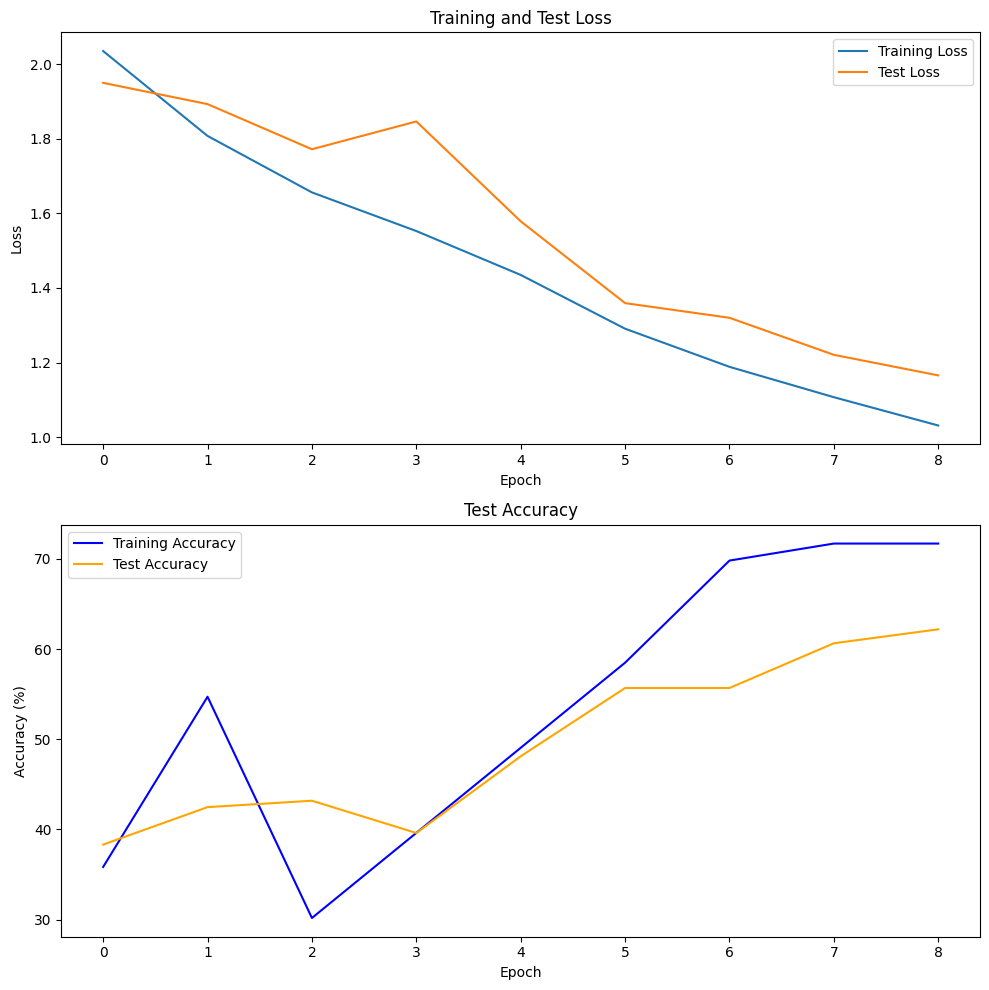

In [12]:
# 손실 및 정확도 시각화
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color='blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Test Accuracy')

plt.tight_layout()
plt.show()

## 파라미터 튜닝

1. 에폭 수 변경

In [ ]:
# 모델, 손실 함수, 최적화 알고리즘 설정
model = myCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# 손실과 정확도를 저장하기 위한 리스트 초기화
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [13]:
# 훈련 및 테스트 실행
best_loss = np.inf
patience = 5  # 성능이 향상되지 않은 상태로 중지할 에포크 수
counter = 0  # 성능이 향상되지 않은 연속된 에포크를 계산할 카운터

# 에포크를 반복
for epoch in range(1, 50):
    # 현재 에포크에 대해 모델을 훈련
    train(model, train_loader, optimizer, epoch)

    # 모델을 테스트하고 손실을 얻음
    loss = test(model, test_loader)

    # 손실이 개선되었는지 확인
    if loss < best_loss:
        best_loss = loss
        counter = 0  # 카운터 초기화
    else:
        counter += 1

    # early stopping 조건을 확인
    if counter >= patience:
        print("에포크", epoch, "후 조기 종료")
        break

Epoch: 1, Training loss: 0.9694
Test loss: 1.1139, Accuracy: 65.12%
Epoch: 2, Training loss: 0.9198
Test loss: 1.1415, Accuracy: 63.38%
Epoch: 3, Training loss: 0.8687
Test loss: 1.1272, Accuracy: 64.64%
Epoch: 4, Training loss: 0.8280
Test loss: 1.1299, Accuracy: 63.96%
Epoch: 5, Training loss: 0.7912
Test loss: 1.0455, Accuracy: 67.83%
Epoch: 6, Training loss: 0.7583
Test loss: 1.0617, Accuracy: 65.67%
Epoch: 7, Training loss: 0.7235
Test loss: 0.9766, Accuracy: 68.05%
Epoch: 8, Training loss: 0.6940
Test loss: 1.0679, Accuracy: 67.09%
Epoch: 9, Training loss: 0.6597
Test loss: 1.0161, Accuracy: 69.31%
Epoch: 10, Training loss: 0.6250
Test loss: 1.0619, Accuracy: 69.53%
Epoch: 11, Training loss: 0.5964
Test loss: 1.0128, Accuracy: 69.79%
Epoch: 12, Training loss: 0.5765
Test loss: 0.9956, Accuracy: 70.21%
에포크 12 후 조기 종료


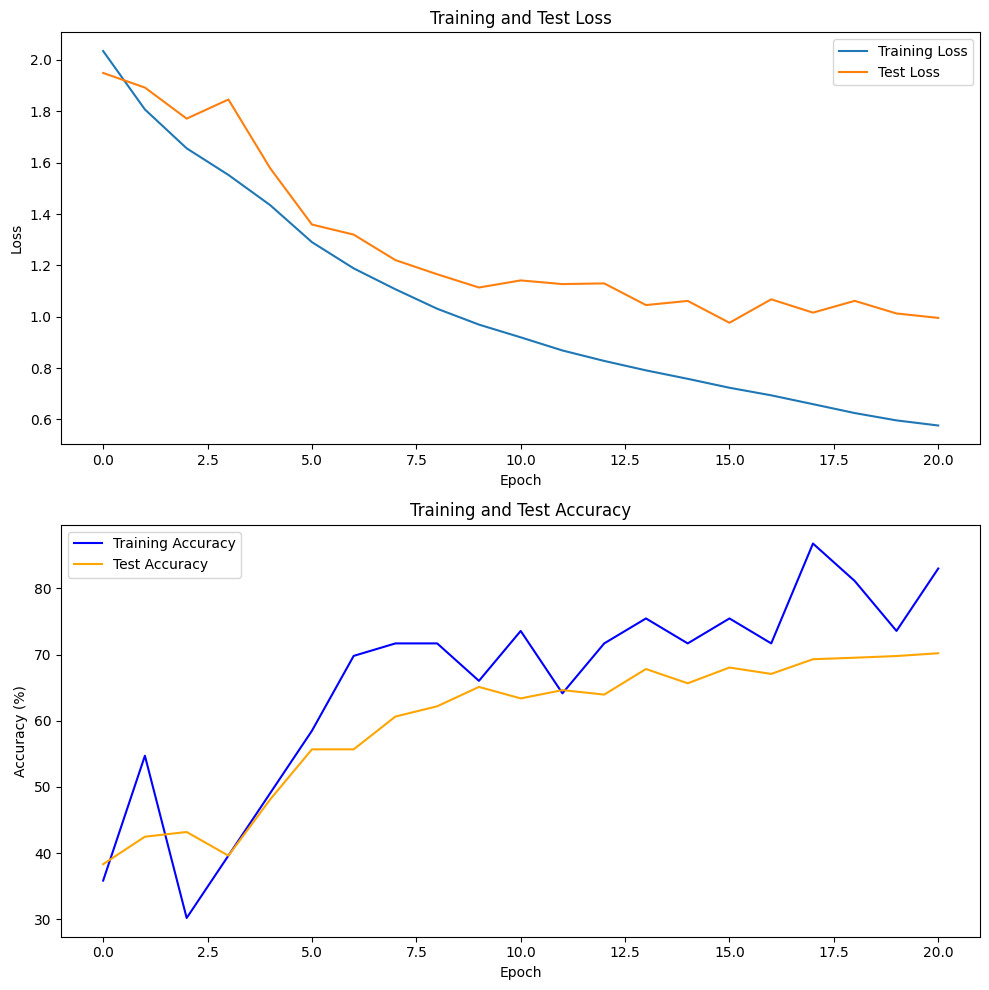

In [14]:
# 손실 및 정확도 시각화
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color='blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Training and Test Accuracy')

plt.tight_layout()
plt.show()

2. layer 추가

In [18]:
# myCNN 클래스 정의
class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=2)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=2)
        self.fc1 = nn.Linear(256*3*3, 256)
        self.fc2 = nn.Linear(256, 12)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = F.relu(F.max_pool2d(self.conv4(x), 2))
        x = F.relu(F.max_pool2d(self.conv5(x), 2))
        x = x.view(-1, 256*3*3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

In [19]:
# 모델, 손실 함수, 최적화 알고리즘 설정
model = myCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# 손실과 정확도를 저장하기 위한 리스트 초기화
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [20]:
# 훈련 및 테스트 실행
best_loss = np.inf
patience = 5  # 성능이 향상되지 않은 상태로 중지할 에포크 수
counter = 0  # 성능이 향상되지 않은 연속된 에포크를 계산할 카운터

# 에포크를 반복
for epoch in range(1, 50):
    # 현재 에포크에 대해 모델을 훈련
    train(model, train_loader, optimizer, epoch)

    # 모델을 테스트하고 손실을 얻음
    loss = test(model, test_loader)

    # 손실이 개선되었는지 확인
    if loss < best_loss:
        best_loss = loss
        counter = 0  # 카운터 초기화
    else:
        counter += 1

    # early stopping 조건을 확인
    if counter >= patience:
        print("에포크", epoch, "후 조기 종료")
        break

Epoch: 1, Training loss: 2.2858
Test loss: 2.1371, Accuracy: 34.30%
Epoch: 2, Training loss: 2.0621
Test loss: 2.0393, Accuracy: 34.75%
Epoch: 3, Training loss: 1.9203
Test loss: 1.9877, Accuracy: 37.10%
Epoch: 4, Training loss: 1.8423
Test loss: 1.9128, Accuracy: 41.32%
Epoch: 5, Training loss: 1.7785
Test loss: 1.8851, Accuracy: 42.54%
Epoch: 6, Training loss: 1.7085
Test loss: 1.8538, Accuracy: 42.48%
Epoch: 7, Training loss: 1.6331
Test loss: 1.7492, Accuracy: 44.25%
Epoch: 8, Training loss: 1.5533
Test loss: 1.8459, Accuracy: 45.31%
Epoch: 9, Training loss: 1.4918
Test loss: 1.6243, Accuracy: 48.28%
Epoch: 10, Training loss: 1.4305
Test loss: 1.5499, Accuracy: 50.37%
Epoch: 11, Training loss: 1.3760
Test loss: 1.5547, Accuracy: 50.14%
Epoch: 12, Training loss: 1.3223
Test loss: 1.4135, Accuracy: 53.82%
Epoch: 13, Training loss: 1.2629
Test loss: 1.3915, Accuracy: 54.85%
Epoch: 14, Training loss: 1.2043
Test loss: 1.3446, Accuracy: 55.43%
Epoch: 15, Training loss: 1.1557
Test loss:

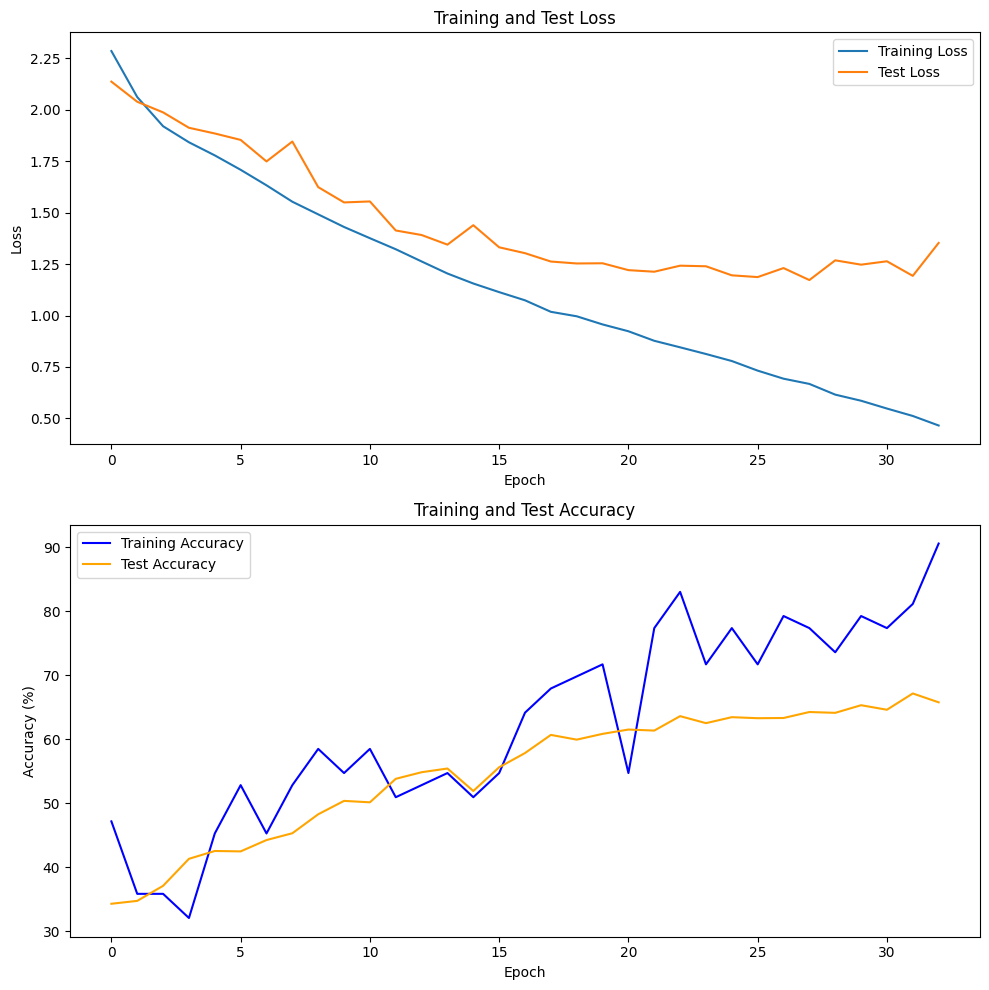

In [21]:
# 손실 및 정확도 시각화
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color='blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Training and Test Accuracy')

plt.tight_layout()
plt.show()

3. 가중치 규제

In [71]:
class myCNN(nn.Module):
    def __init__(self, l2_lambda=0.01):
        super(myCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=2)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=2)
        self.fc1 = nn.Linear(256*3*3, 256)
        self.fc2 = nn.Linear(256, 12)
        self.l2_lambda = l2_lambda
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = F.relu(F.max_pool2d(self.conv4(x), 2))
        x = F.relu(F.max_pool2d(self.conv5(x), 2))
        x = x.view(-1, 256*3*3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        l2_reg = torch.tensor(0.0, device=self.conv1.weight.device)
        for name, param in self.named_parameters():
            if 'weight' in name:
                l2_reg += torch.norm(param, p=2)**2
        
        return F.log_softmax(x, dim=1) + self.l2_lambda * l2_reg


In [72]:
# 모델, 손실 함수, 최적화 알고리즘 설정
model = myCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# 손실과 정확도를 저장하기 위한 리스트 초기화
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [73]:
# 훈련 및 테스트 실행
best_loss = np.inf
patience = 5  # 성능이 향상되지 않은 상태로 중지할 에포크 수
counter = 0  # 성능이 향상되지 않은 연속된 에포크를 계산할 카운터

# 에포크를 반복
for epoch in range(1, 50):
    # 현재 에포크에 대해 모델을 훈련
    train(model, train_loader, optimizer, epoch)

    # 모델을 테스트하고 손실을 얻음
    loss = test(model, test_loader)

    # 손실이 개선되었는지 확인
    if loss < best_loss:
        best_loss = loss
        counter = 0  # 카운터 초기화
    else:
        counter += 1

    # early stopping 조건을 확인
    if counter >= patience:
        print("에포크", epoch, "후 조기 종료")
        break

Epoch: 1, Training loss: 2.2833
Test loss: 2.1173, Accuracy: 34.30%
Epoch: 2, Training loss: 2.0375
Test loss: 2.0245, Accuracy: 38.68%
Epoch: 3, Training loss: 1.9107
Test loss: 2.0101, Accuracy: 35.75%
Epoch: 4, Training loss: 1.8369
Test loss: 1.9681, Accuracy: 41.19%
Epoch: 5, Training loss: 1.7750
Test loss: 1.8676, Accuracy: 41.93%
Epoch: 6, Training loss: 1.7267
Test loss: 1.9401, Accuracy: 43.16%
Epoch: 7, Training loss: 1.6722
Test loss: 1.7426, Accuracy: 44.61%
Epoch: 8, Training loss: 1.5967
Test loss: 1.7451, Accuracy: 45.48%
Epoch: 9, Training loss: 1.5274
Test loss: 1.6065, Accuracy: 47.47%
Epoch: 10, Training loss: 1.4436
Test loss: 1.6131, Accuracy: 49.05%
Epoch: 11, Training loss: 1.3784
Test loss: 1.4758, Accuracy: 50.34%
Epoch: 12, Training loss: 1.3113
Test loss: 1.4495, Accuracy: 51.59%
Epoch: 13, Training loss: 1.2473
Test loss: 1.3681, Accuracy: 54.98%
Epoch: 14, Training loss: 1.1921
Test loss: 1.3763, Accuracy: 55.59%
Epoch: 15, Training loss: 1.1507
Test loss:

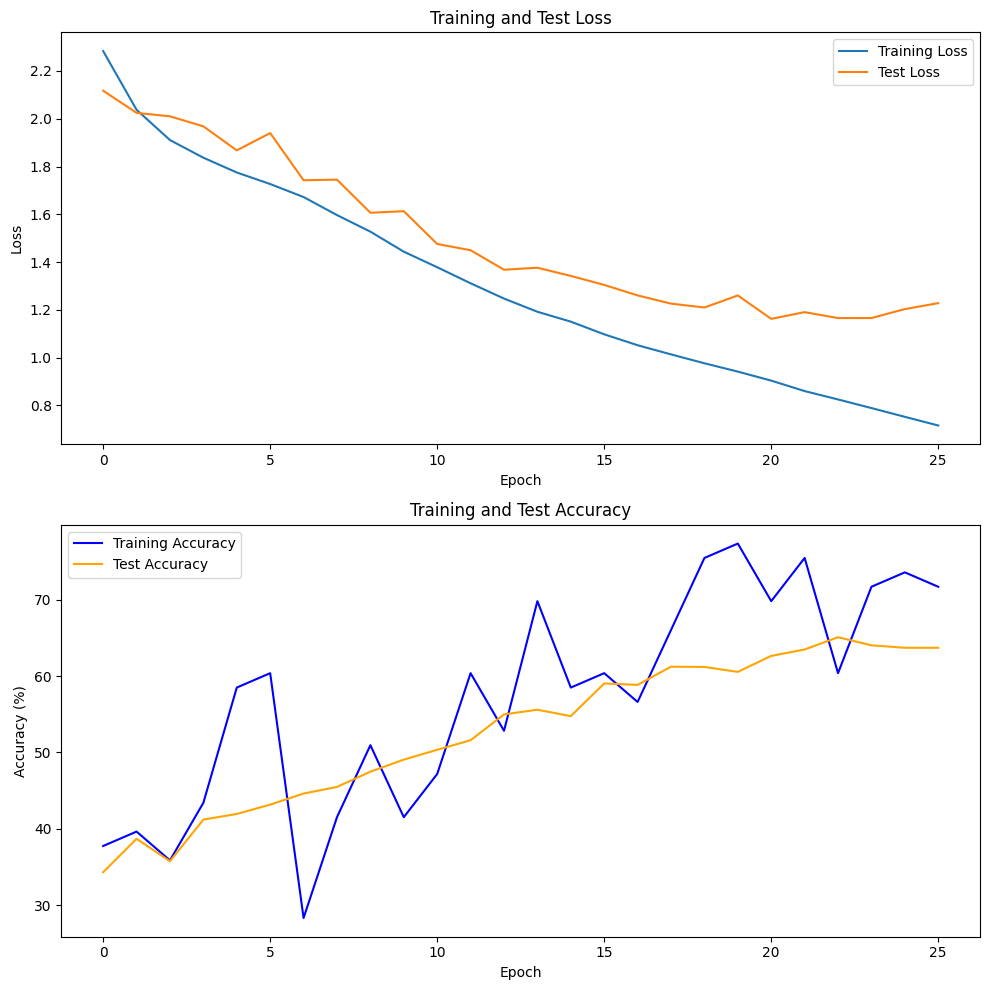

In [74]:
# 손실 및 정확도 시각화
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color='blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Training and Test Accuracy')

plt.tight_layout()
plt.show()